In [ ]:
# pip install -U layoutparser
# pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.1.3#egg=detectron2'
# pip install PyMuPDF pymupdf4llm

# if "AttributeError: module 'PIL.Image' has no attribute 'LINEAR'" occurs,
# downgrade Pillow under pillow<=9.5.0 or 
# install another version of detectron

# 0. data load


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from glob import glob

project_path = '/content/drive/MyDrive/Data/dacon/finance'

data_path = project_path + '/open/train_source'
image_path  = project_path + '/processed/image'

data_file_list = glob(data_path + "/*")
data_file_list.sort()
data_file_list_test  = glob(project_path + "/open/test_source/*")
data_file_list_test.sort()

In [ ]:
data_file_list_test

['/content/drive/MyDrive/Data/dacon/finance/open/test_source/국토교통부_행복주택출자.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/보건복지부_노인장기요양보험 사업운영.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/보건복지부_부모급여(영아수당) 지원.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/산업통상자원부_에너지바우처.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/중소벤처기업부_혁신창업사업화자금(융자).pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》 v2.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 23-2호 《핵심재정사업 성과관리》 v2.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」(신규) 통권 제1호 《우발부채》 v2.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈&포커스」 22-2호

# 1. utils(functions)

In [3]:
import io
import matplotlib.pyplot as plt
from PIL import Image
import pymupdf as fitz

#-----------------------------------------------------------------------
# pdf 의 한 페이지 fitz.Page를 plt 로 시각화 하는 함수
#-----------------------------------------------------------------------
def pdf_visualize(page, rect, matrix=[4, 4], figsize = (11,15),show=True):

    # 페이지 일부를 이미지로 변환
    matrix = fitz.Matrix(*matrix) # 해상도 높이기
    pix = page.get_pixmap(clip=rect, matrix=matrix)


    # 이미지 데이터를 PIL 이미지로 변환
    img = Image.open(io.BytesIO(pix.tobytes()))

    # 이미지를 Jupyter Notebook에서 바로 표시
    if show:
        plt.figure(figsize=figsize)
        plt.imshow(img)
        plt.axis('off')  # 축 숨기기
        plt.show()

    return pix

import pymupdf as fitz  # PyMuPDF

#-----------------------------------------------------------------------
# 합쳐진 페이지를 나눠 새로운 pdf 로 저장하는 함수
#-----------------------------------------------------------------------
def split_pdf_with_fitz(input_pdf_path, output_pdf_path, ratio = 0.8): # a4 용지 비율이 0.7 정도
    # PDF 파일 열기
    pdf_document = fitz.open(input_pdf_path)
    output_pdf = fitz.open()

    for page_num in range(len(pdf_document)):
        page = pdf_document.load_page(page_num)
        rect = page.rect
        width = rect.width
        height = rect.height

        if (width / height) > ratio:
            # 왼쪽 반 분할
            left_rect = fitz.Rect(0, 0, width / 2, height)
            left_page = output_pdf.new_page(width=width / 2, height=height)
            left_page.show_pdf_page(left_rect, pdf_document, page_num, clip=left_rect)

            # 오른쪽 반 분할
            right_rect = fitz.Rect(width / 2, 0, width, height)
            right_page = output_pdf.new_page(width=width / 2, height=height)
            right_page.show_pdf_page(left_rect, pdf_document, page_num, clip=right_rect) # rect(1-param) 이 현 페이지 위치, clip이 source doc page의 위치
        else:
            new_page = output_pdf.new_page(width=width, height=height)
            new_page.show_pdf_page(rect, pdf_document, page_num, clip=rect)

    # 새로운 PDF 저장
    output_pdf.save(output_pdf_path)
    output_pdf.close()
    pdf_document.close()

    print(f"Split PDF saved as {output_pdf_path}")

# # 사용 방법
# split_pdf_with_fitz(data_file_list_test[-1], data_file_list_test[-1].split("/")[-1])
# split_pdf_with_fitz(data_file_list_test[-2], data_file_list_test[-2].split("/")[-1])
# split_pdf_with_fitz(data_file_list_test[-3], data_file_list_test[-3].split("/")[-1])
# split_pdf_with_fitz(data_file_list_test[-4], data_file_list_test[-4].split("/")[-1])
split_pdf_with_fitz('/home/bjh/dacon/pdf/dacon/train_source/「FIS 이슈 & 포커스」 22-3호 《재정융자사업》.pdf', '../ext/「FIS 이슈 & 포커스」 22-3호 《재정융자사업》 2.pdf')

Split PDF saved as ../ext/「FIS 이슈 & 포커스」 22-3호 《재정융자사업》 2.pdf


# 2. pdf to image

In [ ]:
import numpy as np
from PIL import Image
import layoutparser as lp
from typing import Tuple, Literal
from tqdm import tqdm
import pymupdf as fitz
import json

def page2image(page:fitz.Page, rect, matrix=[4, 4]) -> np.ndarray:

    # 페이지 일부를 이미지로 변환
    matrix = fitz.Matrix(*matrix)                              # 해상도 높이기
    pix = page.get_pixmap(clip=rect, matrix=matrix)            # pixmap 변환
    image_np = np.frombuffer(pix.samples, dtype=np.uint8)      # ndarray 변환
    image_np = image_np.reshape(pix.height, pix.width, pix.n)  # reshape

    return image_np

def layout_parsing(model, doc:fitz.Document, start_page=0, end_page=None, output_dir="") -> Tuple[dict, dict, list]: # model: lp.models.detectron2.layoutmodel.Detectron2LayoutModel
    if end_page is None:
        end_page = doc.page_count

    layouts, tables, images = [], {}, {}
    for i in tqdm(range(start_page, end_page), desc="parsing"):
        page = doc.load_page(i)                  # load page
        image_np = page2image(page, page.rect)   # convert page(fitz) to image(np)
        layout = model.detect(image_np)          # detect layout
        layouts.append(layout)

        # convert coordinate(scale) from image to pdf
        height_i, width_i, _ = image_np.shape
        [x1p, y1p, x2p, y2p], width_p, height_p = page.rect, page.rect.width, page.rect.height
        layout_dict = layout.to_dict()

        # extract table and figure location
        for block in layout_dict['blocks']:
            _type = block['type']
            score = block['score']
            x1, y1, x2, y2 = block['x_1']/width_i, block['y_1']/height_i, block['x_2']/width_i, block['y_2']/height_i
            x1, y1, x2, y2 = x1*width_p, y1*height_p, x2*width_p, y2*height_p
            if _type == 'Table':
                tables.setdefault(i, []).append([x1, y1, x2, y2])
            elif _type == 'Figure':
                images.setdefault(i, []).append([x1, y1, x2, y2])

        output_path = output_dir + doc.name.split("/")[-1].replace(".pdf", "") + ".json"

        dict_ = {"tables":tables, "images":images}
        with open(output_path, "w") as f:
            json.dump(dict_, f)



    return tables, images, layouts

In [ ]:
import layoutparser as lp


model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config', # 3000x4000x3 이미지당 20s(cpu), 0.5s(T4 GPU)
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.75],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

config.yaml?dl=1: 8.19kB [00:02, 3.72kB/s]
model_final.pth?dl=1: 856MB [00:54, 15.6MB/s]                           


In [ ]:
doc_path = data_file_list[-1]
doc = fitz.Document(doc_path)
output_dir="/content/drive/MyDrive/Data/dacon/finance/processed/layout2/"

for doc_path in data_file_list_test:
    doc = fitz.Document(doc_path)
    print(doc)
    tables, images, layouts = layout_parsing(model, doc, output_dir=output_dir)

Document('/content/drive/MyDrive/Data/dacon/finance/open/test_source/국토교통부_행복주택출자.pdf')


parsing: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Document('/content/drive/MyDrive/Data/dacon/finance/open/test_source/보건복지부_노인장기요양보험 사업운영.pdf')


parsing: 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Document('/content/drive/MyDrive/Data/dacon/finance/open/test_source/보건복지부_부모급여(영아수당) 지원.pdf')


parsing: 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Document('/content/drive/MyDrive/Data/dacon/finance/open/test_source/산업통상자원부_에너지바우처.pdf')


parsing: 100%|██████████| 11/11 [00:04<00:00,  2.74it/s]


Document('/content/drive/MyDrive/Data/dacon/finance/open/test_source/중소벤처기업부_혁신창업사업화자금(융자).pdf')


parsing: 100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Document('/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》 v2.pdf')


parsing: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Document('/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 23-2호 《핵심재정사업 성과관리》 v2.pdf')


parsing: 100%|██████████| 20/20 [00:12<00:00,  1.67it/s]


Document('/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」(신규) 통권 제1호 《우발부채》 v2.pdf')


parsing: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]


Document('/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈&포커스」 22-2호 《재정성과관리제도》 v2.pdf')


parsing: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]


In [ ]:
page = fitz.Document(data_file_list[0])[33]
page_np = page2image(page, page.rect, matrix=[8, 8])
layout = model.detect(page_np)
layout

Layout(_blocks=[], page_data={})

# 3. table(image) head 찾기 & 크기 조정

In [ ]:
layout_path  = project_path + '/processed/layout2'
layout_file_list = glob(layout_path + "/*")
layout_file_list.sort()
layout_file_list

['/content/drive/MyDrive/Data/dacon/finance/processed/layout2/국토교통부_행복주택출자.json',
 '/content/drive/MyDrive/Data/dacon/finance/processed/layout2/보건복지부_노인장기요양보험 사업운영.json',
 '/content/drive/MyDrive/Data/dacon/finance/processed/layout2/보건복지부_부모급여(영아수당) 지원.json',
 '/content/drive/MyDrive/Data/dacon/finance/processed/layout2/산업통상자원부_에너지바우처.json',
 '/content/drive/MyDrive/Data/dacon/finance/processed/layout2/중소벤처기업부_혁신창업사업화자금(융자).json',
 '/content/drive/MyDrive/Data/dacon/finance/processed/layout2/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》 v2.json',
 '/content/drive/MyDrive/Data/dacon/finance/processed/layout2/「FIS 이슈 & 포커스」 23-2호 《핵심재정사업 성과관리》 v2.json',
 '/content/drive/MyDrive/Data/dacon/finance/processed/layout2/「FIS 이슈 & 포커스」(신규) 통권 제1호 《우발부채》 v2.json',
 '/content/drive/MyDrive/Data/dacon/finance/processed/layout2/「FIS 이

In [ ]:
import json

layouts = []
for layout_file in layout_file_list:
    with open(layout_file) as json_file:
        layout = json.load(json_file)
        layouts.append(layout)

In [ ]:
layouts[0]

{'tables': {'2': [[70.28443402397086,
    465.18422298612967,
    537.6542232374901,
    703.8299259561824]],
  '3': [[58.784294251485484,
    323.6926062737598,
    537.6431800478226,
    649.7543488419715]],
  '5': [[55.98694677490234,
    324.8837653568143,
    533.0027829398887,
    542.7625280203576]],
  '6': [[61.17593797175393,
    207.08030766182338,
    532.4129789922915,
    408.269081532703],
   [65.17891881641823,
    609.5299895345952,
    538.2430509915255,
    716.9253831213415]],
  '7': [[56.25258582138466,
    291.1594113744441,
    527.0800945764825,
    487.67859875155955]],
  '8': [[65.23305180002282,
    183.0697725470888,
    539.3931900435741,
    288.79729320610613],
   [57.05619522528825,
    520.4752785160589,
    540.0681058673374,
    636.0807201394064]],
  '9': [[56.946426835175416,
    98.96944663137188,
    530.1832918851292,
    177.14137833725192]],
  '10': [[63.56894683770641,
    278.5313308948691,
    536.6558212721978,
    379.493849058567]],
  '11'

In [ ]:
from typing import Tuple, Literal, List

def find_table_image_title(typeS: dict, page:fitz.Page, location:fitz.Rect, tolerance:int=5, fontsize:int=10, direction:Literal["top", "bottom", "both"]="top"): # -> Tuple[fitz.Rect, str]:
    '''
    typeS = {"table":"표", "image": "그림"}
    '''
    x1, y1, x2, y2 = location
    minx, miny, maxx, maxy = page.rect
    # search top
    if direction == "top" or direction == "both":
        for i in range(tolerance+1):
            _x1, _y1, _x2, _y2 = max(minx, x1-(fontsize*i)), max(miny, y1-(fontsize*i)), min(maxx, x2+(fontsize*i)), min(maxy, y1+(fontsize*2))

            # Search Title
            rects = page.search_for(typeS["table"], clip=fitz.Rect(_x1, _y1, _x2, _y2))
            _type = "table"
            if len(rects) <= 0:
                rects = page.search_for(typeS["image"], clip=fitz.Rect(_x1, _y1, _x2, _y2))
                _type = "image"

            if len(rects) > 0:
                # 가장 가까운것 하나 고르기
                titleRect, closey = None, 0
                for rect in rects:
                    if abs(rect[1] - rect[3]) < fontsize*2:
                        if closey < rect[1]:
                            closey = rect[1]
                            titleRect = rect

                _x1, _y1, _x2, _y2 = titleRect
                titleRect = fitz.Rect(min(x1, _x1), _y1, max(_x2, x2), _y2)
                title_blocks = page.get_text("dict", clip=titleRect)["blocks"]
                title_spans = [span for block in title_blocks for line in block["lines"] for span in line["spans"]]
                title_spans = sorted(title_spans, key=lambda s: (s["bbox"][0], s["bbox"][1]))
                title = "  ".join([s["text"] for s in title_spans])
                return _type, fitz.Rect(min(x1, _x1), _y2, max(_x2, x2), y2), title


    # search bottom:
    if direction == "bottom" or direction == "both":
        raise NotImplementedError

    return "", None, ""

def get_horizontal_lines(page:fitz.Page, area:fitz.Rect, width=10, vector=True, rect=True):
    # vector graphic
    if vector:
        shapes = page.get_drawings()
        items = [fitz.Rect(item[1], item[2]) for shape in shapes for item in shape.setdefault('items', []) if item[0] == 'l' and item[1][1] - item[2][1] < 1e-5] #lines
        if rect:
            items += [item[1] for shape in shapes for item in shape.setdefault('items', []) if item[0] == 're']
        items = [v for item in items if item in area and item.width >= 10 for v in (item[1], item[3])] # take y position in location
        return items

def adjust_table_size(page:fitz.Page, location:fitz.Rect, tolerance:int=0, fontsize:int=10, horizontal=False, htolerance=1) -> List[int]: # [x1, y1, x2, y2]
    x1, y1, x2, y2 = location
    x_min, y_min, x_max, y_max = page.rect

    if horizontal: # table 의 horizontal line 으로 크기 추측
        pad = fontsize*htolerance # 3~5 글자, location.width / 2 는 cell 별로 잘려진 경우 소용 없음
        area = fitz.Rect(x_min, y1-pad, x_max, y2+pad)
        items = get_horizontal_lines(page, area, width=pad)
        if len(items) > 1:
            y1, y2 = min(items)-pad, max(items)+pad
            print(y1, y2)


    pad = fontsize*tolerance
    table_rec = [max(x_min, x1-pad), max(y_min, y1-pad), min(x_max, x2+pad), min(y_max, y2+pad)]

    table_blocks = page.get_text("dict", clip=[x1, y1, x2, y2])["blocks"]
    table_spans = [span for block in table_blocks for line in block.setdefault("lines", []) for span in line.setdefault("spans", [])]

    tx_min, ty_min, tx_max, ty_max = location
    if len(table_spans) > 0:
        tx_min, ty_min = min([s['bbox'][0] for s in table_spans]), min([s['bbox'][1] for s in table_spans])
        tx_max, ty_max = max([s['bbox'][2] for s in table_spans]), max([s['bbox'][3] for s in table_spans])

    return [min(x1, tx_min), min(y1, ty_min), max(x2, tx_max), max(y2, ty_max)]

def is_no_text(page, clip):
    return page.get_text('text', clip=clip) == ""

def is_bottom(page:fitz.Page, locations:List[fitz.Rect], index=-1, margin=70): # 2/23
    if len(locations) > 0:
        x1, y1, x2, y2 = locations[index]
        _, _, _, max_y = page.rect
        max_y -= margin

        if y2 >= max_y:
            return True
        elif is_no_text(page, [x1, y2, x2, max_y]):
            return True
    return False

def is_top(page:fitz.Page, location:fitz.Rect, margin=90): # 2.7/23
    x1, y1, x2, y2 = location
    _, min_y, _, _ = page.rect
    min_y += margin

    if y1 <= min_y:
        return True
    elif is_no_text(page, [x1, min_y, x2, y1]):
        return True
    return False

def split_table_image(typeD:str, typeS: dict, page:fitz.Page, location:fitz.Rect, is_prev=False, prev_title:str="", prev_type=None, threshold=50,
                      min_height:int=40, margin=70, tolerance:int=3, fontsize:int=10, direction:Literal["top", "bottom", "both"]="top"):
    # 여러개의 이미지 및 테이블이 합쳐진 경우 분리.
    if is_no_text(page,location):
        return {key:[] for key in typeS.keys()}, {"is_prev": False, "prev_type": "", "prev_title": ""}


    location_ = adjust_table_size(page, location)
    x1, min_y, x2, max_y = location_
    min_y, max_y = max(margin, min_y), min(page.rect.height - margin, max_y)
    rects, figures = [], []

    # find "표" or "이미지" in dict
    for type_s, search_s in typeS.items():
        rects += page.search_for(search_s, clip=location_)

    # split image
    rects.sort(key=lambda x:(x[1], x[2]))
    rects.append(fitz.Rect(0, max_y, 0, max_y))
    if direction == "top":
        prev_y = min_y
        for _, curr_y, _, _ in rects:
            if curr_y - prev_y > min_height and not is_no_text(page, [x1, prev_y, x2, curr_y]):
                figures.append(fitz.Rect(x1, prev_y, x2, curr_y))
            prev_y = curr_y
    else:
        raise NotImplementedError

    # for each splited images find title
    result = {key:[] for key in typeS.keys()}
    lindex = len(figures)-1
    currt, currTitle = "", ""
    for index, rect in enumerate(figures):
        rect = adjust_table_size(page, rect, horizontal=True)
        type_, rect_, title = find_table_image_title(typeS, page, rect, tolerance=tolerance, fontsize=fontsize, direction=direction)
        if type_ == "":
            if is_prev and is_top(page, rect) and typeD=="table":
                type_, rect_, title = prev_type, fitz.Rect(rect), prev_title
            elif abs(rect[3]-rect[1]) > threshold:
                type_, rect_, title = typeD, fitz.Rect(rect), ""

        if type_ != "":
            result[type_].append({"bbox":rect_, "title":title})
        if index == lindex:
            currt, currTitle = type_, title


    return result, {"is_prev": is_bottom(page, figures, -1, margin), "prev_type": currt, "prev_title":currTitle}

doc_n = -4
pno = 2

layout = layouts[doc_n]
doc_path = data_file_list_test[doc_n]
doc = fitz.Document(doc_path)

temp_rect = layout["tables"][str(pno)][0]
page = doc.load_page(pno)

result, prev= split_table_image("table", {"table":"<표 ", "image":"<그림"}, page, fitz.Rect(temp_rect))
print(temp_rect, result)

454.6070251464844 712.7171020507812
[70.28443402397086, 465.18422298612967, 537.6542232374901, 703.8299259561824] {'table': [{'bbox': Rect(68.64031982421875, 455.264404296875, 537.6542232374901, 719.4461059570312), 'title': '<표 1> 지방재정조정제도의 유형과 구분'}], 'image': []}


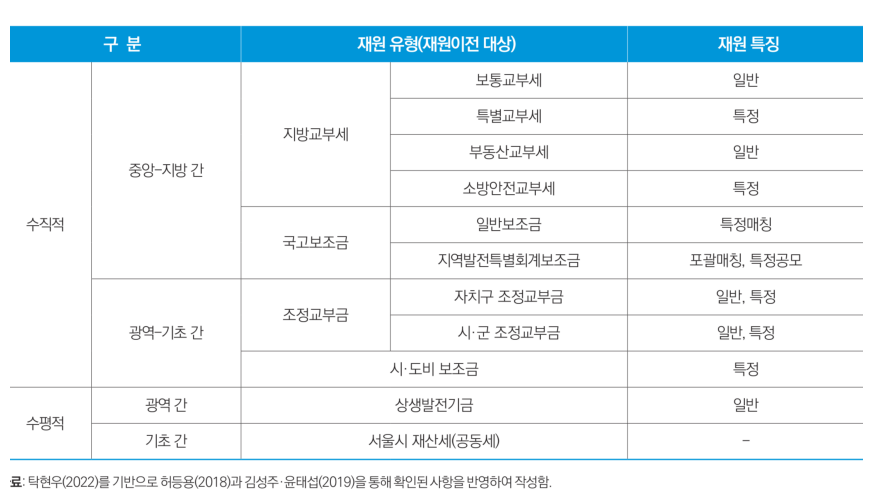

({'table': [{'bbox': Rect(68.64031982421875, 455.264404296875, 537.6542232374901, 719.4461059570312),
    'title': '<표 1> 지방재정조정제도의 유형과 구분'}],
  'image': []},
 {'is_prev': False,
  'prev_type': 'table',
  'prev_title': '<표 1> 지방재정조정제도의 유형과 구분'},
 [[70.28443402397086,
   465.18422298612967,
   537.6542232374901,
   703.8299259561824]],
 Pixmap(DeviceRGB, (274, 1821, 2151, 2878), 0))

In [ ]:
result, prev, layout["tables"][str(pno)], pdf_visualize(page, [68.64031982421875, 455.264404296875, 537.6542232374901, 719.4461059570312])


In [ ]:
data_file_list_test

['/content/drive/MyDrive/Data/dacon/finance/open/test_source/국토교통부_행복주택출자.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/보건복지부_노인장기요양보험 사업운영.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/보건복지부_부모급여(영아수당) 지원.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/산업통상자원부_에너지바우처.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/중소벤처기업부_혁신창업사업화자금(융자).pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》 v2.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 23-2호 《핵심재정사업 성과관리》 v2.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」(신규) 통권 제1호 《우발부채》 v2.pdf',
 '/content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈&포커스」 22-2호

In [ ]:
# target_doc = [
#     [0, 26, {"table":"[표", "image":"[그림"}], # 1-1 2024 주요 재정통계 1권.pdf
#     [1, 3, {"table":"[표", "image":"[그래프"}],  # 2024 나라살림 예산개요.pdf
#     [11, 3, {"table":"<표", "image":"<그림"}], # 월간 나라재정 2023년 12월호.pdf
#     [12, 9, {"table":"표 ", "image":"그림"}], # 재정통계해설.pdf
#     [14, 1, {"table":"<표", "image":"<그림"}], # 「FIS 이슈 & 포커스」 23-3호 《조세지출 연계관리》 v2.pdf
#     [15, 1, {"table":"<표", "image":"<그림"}]  # 「FIS 이슈 & 포커스」 22-3호 《재정융자사업》 v2.pdf
# ]

target_doc = [
    [5, 1, {"table":"<표", "image":"<그림"}], # 「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》 v2.pdf',
    [6, 1, {"table":"<표", "image":"<그림"}], # 「FIS 이슈 & 포커스」 23-2호 《핵심재정사업 성과관리》 v2.pdf',
    [7, 1, {"table":"<표", "image":"<그림"}], # 「FIS 이슈 & 포커스」(신규) 통권 제1호 《우발부채》 v2.pdf',
    [8, 1, {"table":"<표", "image":"<그림"}], # 「FIS 이슈&포커스」 22-2호 《재정성과관리제도》 v2.pdf'
]

docs_processed = {}

def processing_layout1(doc_n, start_page, title_dict={"table":"표", "image":"그림"}):
    tables_new, images_new = {}, {}

    doc = fitz.Document(data_file_list_test[doc_n])
    layout = layouts[doc_n]


    table_keys = layout["tables"].keys()
    image_keys = layout["images"].keys()
    prev = {"is_prev": False, "prev_type": "", "prev_title": ""}

    for pno in range(start_page, doc.page_count):
        page = doc.load_page(pno)
        flag = False
        if str(pno) in table_keys:
            print(page, layout["tables"][str(pno)])
            for rect in layout["tables"][str(pno)]:
                result, prev_t = split_table_image("table", title_dict, page, rect, **prev)
                if len(result['table']) > 0 : tables_new.setdefault(str(pno), []).extend(result['table'])
                if len(result['image']) > 0 : images_new.setdefault(str(pno), []).extend(result['image'])
                if prev_t["is_prev"]: prev = prev_t

        if str(pno) in image_keys:
            print(page, layout["images"][str(pno)])
            for rect in layout["images"][str(pno)]:
                result, prev_i = split_table_image("image", title_dict, page, rect, **prev)
                if len(result['table']) > 0 : tables_new.setdefault(str(pno), []).extend(result['table'])
                if len(result['image']) > 0 : images_new.setdefault(str(pno), []).extend(result['image'])
                elif prev_i["is_prev"]: prev = prev_i

    return tables_new, images_new

for doc_n, start_page, title_dict in target_doc:
    print(doc_n)
    tables_new, images_new = processing_layout1(doc_n, start_page, title_dict)
    docs_processed[doc_n] = {"tables": tables_new, "images": images_new}




5
page 2 of /content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》 v2.pdf [[70.28443402397086, 465.18422298612967, 537.6542232374901, 703.8299259561824]]
454.6070251464844 712.7171020507812
page 3 of /content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》 v2.pdf [[58.784294251485484, 323.6926062737598, 537.6431800478226, 649.7543488419715]]
312.0159912109375 654.8865356445312
page 5 of /content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》 v2.pdf [[55.98694677490234, 324.8837653568143, 533.0027829398887, 542.7625280203576]]
313.90704345703125 552.1741943359375
page 6 of /content/drive/MyDrive/Data/dacon/finance/open/test_source/「FIS 이슈 & 포커스」 22-4호 《중앙-지방 간 재정조정제도》 v2.pdf [[61.17593797175393, 207.08030766182338, 532.4129789922915, 408.269081532703], [65.17891881641823, 609

In [ ]:
for doc in docs_processed.values():
    tables, images = doc['tables'], doc['images']
    for table in tables.values():
        for t in table:
            t['bbox'] = list(t['bbox'])
    for image in images.values():
        for i in image:
            i['bbox'] = list(i['bbox'])

with open('./table_image_detect_detectron_test.json', "w") as f:
    json.dump(docs_processed, f)


In [ ]:
with open('/content/drive/MyDrive/Data/dacon/finance/processed/table_image_detect_detectron_test.json', 'r') as f:
    json_data = json.load(f)

json_data

{'5': {'tables': {'2': [{'bbox': [68.64031982421875,
      455.264404296875,
      537.6542232374901,
      719.4461059570312],
     'title': '<표 1> 지방재정조정제도의 유형과 구분'}],
   '3': [{'bbox': [57.04719924926758,
      312.67340087890625,
      537.6431800478226,
      661.6154174804688],
     'title': '<표 2> 중앙-지방 간 재정조정제도 : 지방교부세와 국고보조금 비교  '}],
   '5': [{'bbox': [55.98694677490234,
      314.5640869140625,
      533.26708984375,
      558.9031982421875],
     'title': '<표 3> 중앙정부와 지방자치단체의 예산규모 비교    (단위:조원%)'}],
   '6': [{'bbox': [61.17593797175393,
      197.6888427734375,
      536.5220336914062,
      420.25323486328125],
     'title': '<표 4> 지방자치단체의 세입재원별 예산규모  (단위:억원%)'},
    {'bbox': [62.36279296875,
      601.7259521484375,
      538.5828247070312,
      734.0964965820312],
     'title': '<표 5> 중앙정부의 지방재정조정을 위한 재원이전 추이(2013~2022)  (단위:억원%)'}],
   '7': [{'bbox': [56.25258582138466,
      282.20098876953125,
      530.8512573242188,
      503.859619140625],
     'title': '<표 6> 지방교부

2 image <그림 1> 프로그램 예산체계 개념


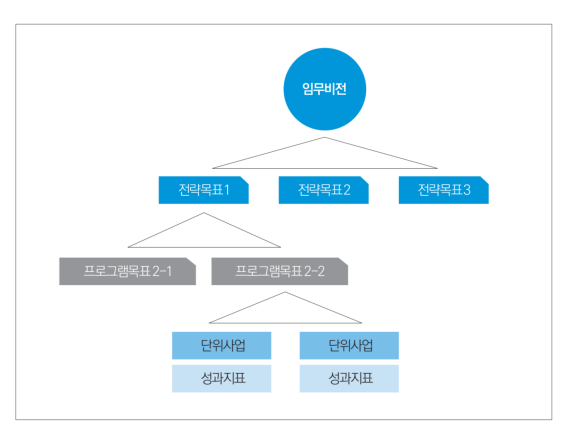

4 image <그림 2> 재정성과관리 개념


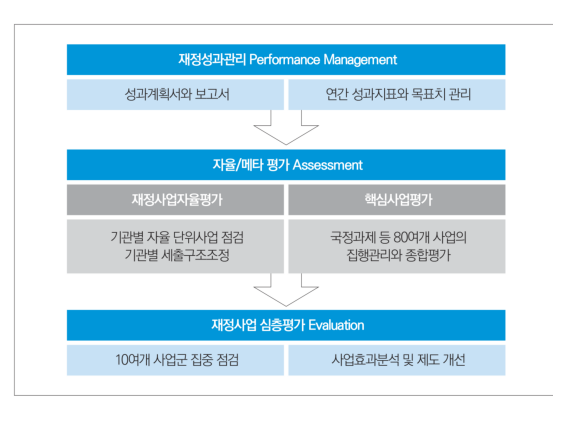

5 table <표 1> 최근 5년간 성과관리 대상 사업 규모 추이  (조원%)


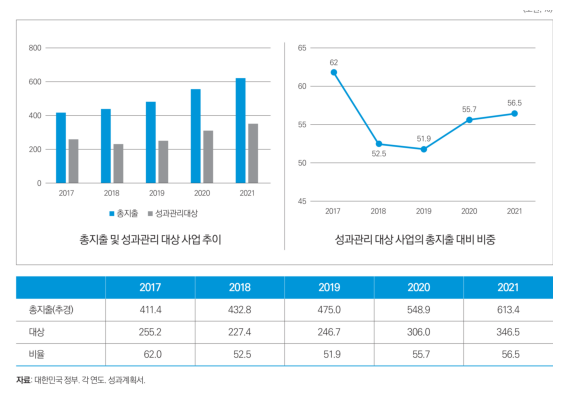

6 table <표 3> 2021년도 주요 부처의 프로그램 성과관리 결과  (개%)


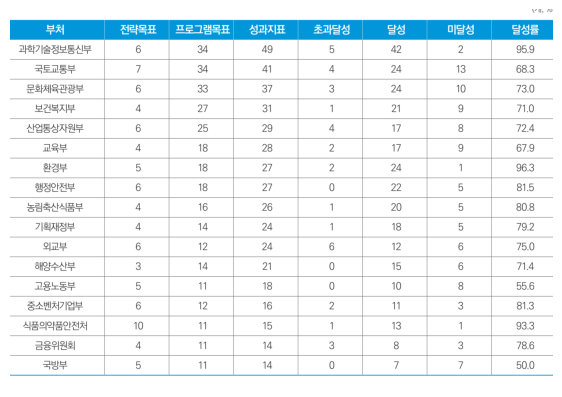

6 table <표 2> 최근 5년간 프로그램 성과관리 현황  (개%)


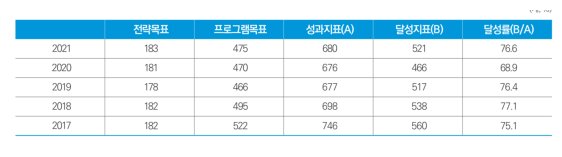

7 table <표 4> 최근 5년간 단위사업 성과관리 현황  (개%)


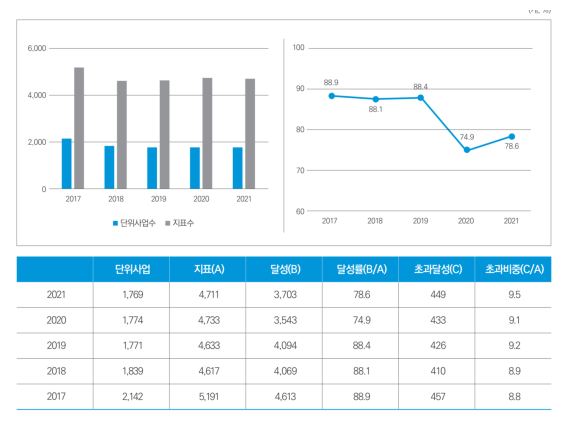

8 table <표 5> 2021년도 주요 부처의 단위사업 지표 관리 결과  (개%)


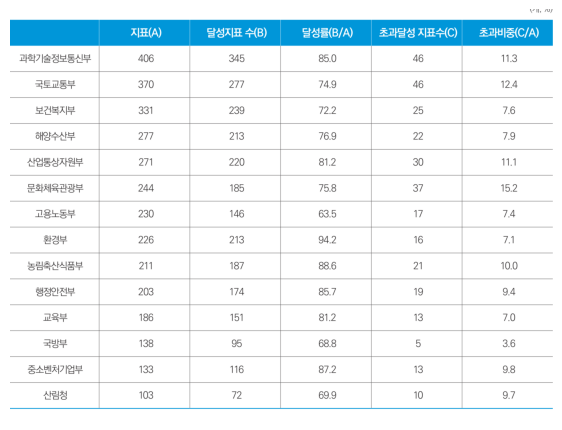

8 table <표 6> 자율평가 구조조정 제도 전년 대비 변화


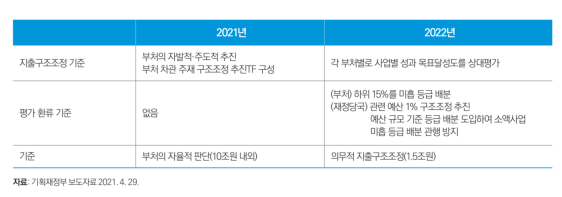

9 table <표 7> 2021년도 주요 부처의 재정사업자율평가 결과


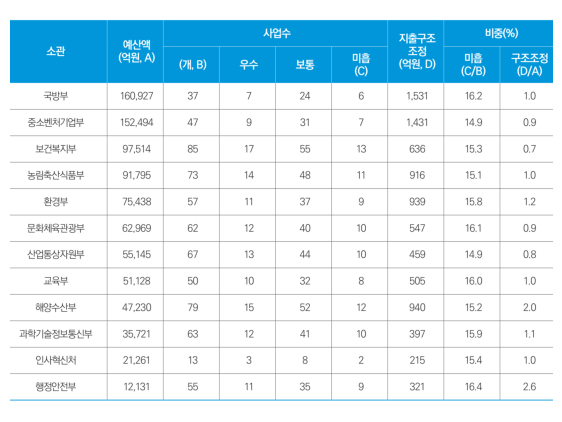

12 table <표 8> 재정사업 자율평가 연혁


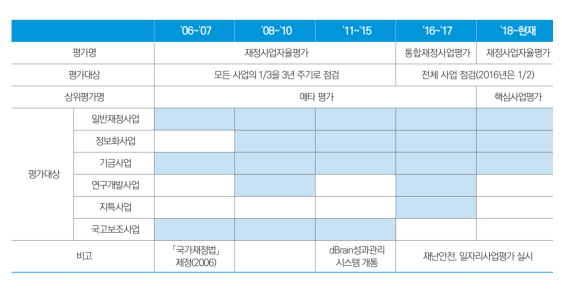

13 image 


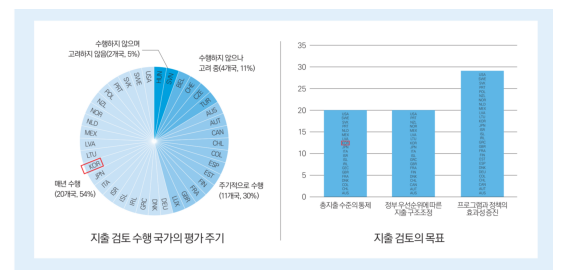

In [ ]:
# target_doc = [0, 1, 11, 12, 14, 15]
target_doc = [5, 6, 7, 8]

MAXPAGE = 10000
doc_n = 8


doc = fitz.Document(data_file_list_test[doc_n])
doc_tables = docs_processed[doc_n]['tables']
doc_images = docs_processed[doc_n]['images']
table_pages = list(doc_tables.keys())
iamge_pages = list(doc_images.keys())
types = ['table', 'image']

while len(table_pages) > 0 or len(iamge_pages) > 0:
    t_small = int(table_pages[0]) if len(table_pages) > 0 else MAXPAGE
    i_small = int(iamge_pages[0]) if len(iamge_pages) > 0 else MAXPAGE
    t_ele = doc_tables[str(t_small)] if t_small < MAXPAGE else None
    i_ele = doc_images[str(i_small)] if i_small < MAXPAGE else None

    pno, types, elements = 0, [], []
    if t_small < i_small:
        pno, types, elements = t_small, ['table'], [t_ele]
        table_pages.pop(0)
    elif t_small > i_small:
        pno, types, elements = i_small, ['image'], [i_ele]
        iamge_pages.pop(0)
    else:
        pno, types, elements = t_small, ['table', 'image'], [t_ele, i_ele]
        table_pages.pop(0)
        iamge_pages.pop(0)

    page = doc[pno]
    for t, eles in zip(types, elements):
        for ele in eles:
            print(pno, t, ele['title'])
            pdf_visualize(page, ele['bbox'], figsize = (7, 8))

